## Introduction to Semantic Chunking
Text chunking is an essential step in Retrieval-Augmented Generation (RAG), where large text bodies are divided into meaningful segments to improve retrieval accuracy.
Unlike fixed-length chunking, semantic chunking splits text based on the content similarity between sentences.

### Breakpoint Methods:
- **Percentile**: Finds the Xth percentile of all similarity differences and splits chunks where the drop is greater than this value.
- **Standard Deviation**: Splits where similarity drops more than X standard deviations below the mean.
- **Interquartile Range (IQR)**: Uses the interquartile distance (Q3 - Q1) to determine split points.

This notebook implements semantic chunking **using the percentile method** and evaluates its performance on a sample text.

## Setting Up the Environment
We begin by importing necessary libraries.

In [24]:
import fitz
import os
import matplotlib.pyplot as plt
import numpy as np
import json
from openai import OpenAI
import matplotlib.pyplot as plt



In [25]:
# Custom .env parser
import os
from pathlib import Path

def parse_env_file():
    env_path = Path.cwd() / '.env'
    with open(env_path, 'r') as f:
        for line in f:
            line = line.strip()
            # Skip comments and empty lines
            if not line or line.startswith('#'):
                continue
            # Split at the first equals sign
            if '=' in line:
                key, value = line.split('=', 1)
                # Remove quotes if present
                value = value.strip('"\'')
                # Set the environment variable
                os.environ[key] = value
                print(f"Set environment variable: {key}")

# Run the custom parser
parse_env_file()

# Check if it worked
nebius_api_key = os.getenv('NEBIUS_API_KEY')
nebius_key = nebius_api_key
print(f"Nebius API key loaded: {'Yes' if nebius_key else 'No'}")
if nebius_key:
    print(f"First few characters: {nebius_key[:10]}...")

Set environment variable: OPENAI_API_KEY
Set environment variable: NEBIUS_API_KEY
Nebius API key loaded: Yes
First few characters: eyJhbGciOi...


## Extracting Text from a PDF File
To implement RAG, we first need a source of textual data. In this case, we extract text from a PDF file using the PyMuPDF library.

In [26]:
def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a PDF file.

    Args:
    pdf_path (str): Path to the PDF file.

    Returns:
    str: Extracted text from the PDF.
    """
    # Open the PDF file
    mypdf = fitz.open(pdf_path)
    all_text = ""  # Initialize an empty string to store the extracted text
    
    # Iterate through each page in the PDF
    for page in mypdf:
        # Extract text from the current page and add spacing
        all_text += page.get_text("text") + " "

    # Return the extracted text, stripped of leading/trailing whitespace
    return all_text.strip()

# Define the path to the PDF file
pdf_path = "data/AI_Information.pdf"

# Extract text from the PDF file
extracted_text = extract_text_from_pdf(pdf_path)

# Print the first 500 characters of the extracted text
print(extracted_text[:500])

Understanding Artificial Intelligence 
Chapter 1: Introduction to Artificial Intelligence 
Artificial intelligence (AI) refers to the ability of a digital computer or computer-controlled robot 
to perform tasks commonly associated with intelligent beings. The term is frequently applied to 
the project of developing systems endowed with the intellectual processes characteristic of 
humans, such as the ability to reason, discover meaning, generalize, or learn from past 
experience. Over the past f


## Setting Up the OpenAI API Client
We initialize the OpenAI client to generate embeddings and responses.

In [27]:
# Initialize the OpenAI client with the base URL and API key
# client = OpenAI(
#     base_url="https://api.studio.nebius.com/v1/",
#     api_key=os.getenv("NEBIUS_API_KEY")  # Retrieve the API key from environment variables
# )

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=nebius_api_key
)


## Creating Sentence-Level Embeddings
We split text into sentences and generate embeddings.

In [28]:
def get_embedding(text, model="BAAI/bge-en-icl"):
    """
    Creates an embedding for the given text using OpenAI.

    Args:
    text (str): Input text.
    model (str): Embedding model name.

    Returns:
    np.ndarray: The embedding vector.
    """
    response = client.embeddings.create(model=model, input=text)
    return np.array(response.data[0].embedding)

# Splitting text into sentences (basic split)
sentences = extracted_text.split(". ")

# Generate embeddings for each sentence
embeddings = [get_embedding(sentence) for sentence in sentences]

print(f"Generated {len(embeddings)} sentence embeddings.")

Generated 257 sentence embeddings.


## Calculating Similarity Differences
We compute cosine similarity between consecutive sentences.

In [29]:
def cosine_similarity(vec1, vec2):
    """
    Computes cosine similarity between two vectors.

    Args:
    vec1 (np.ndarray): First vector.
    vec2 (np.ndarray): Second vector.

    Returns:
    float: Cosine similarity.
    """
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Compute similarity between consecutive sentences
similarities = [cosine_similarity(embeddings[i], embeddings[i + 1]) for i in range(len(embeddings) - 1)]

## Implementing Semantic Chunking
We implement three different methods for finding breakpoints.

In [30]:
def compute_breakpoints(similarities, method="percentile", threshold=90):
    """
    Computes chunking breakpoints based on similarity drops.

    Args:
    similarities (List[float]): List of similarity scores between sentences.
    method (str): 'percentile', 'standard_deviation', or 'interquartile'.
    threshold (float): Threshold value (percentile for 'percentile', std devs for 'standard_deviation').

    Returns:
    List[int]: Indices where chunk splits should occur.
    """
    # Determine the threshold value based on the selected method
    if method == "percentile":
        # Calculate the Xth percentile of the similarity scores
        threshold_value = np.percentile(similarities, threshold)
    elif method == "standard_deviation":
        # Calculate the mean and standard deviation of the similarity scores
        mean = np.mean(similarities)
        std_dev = np.std(similarities)
        # Set the threshold value to mean minus X standard deviations
        threshold_value = mean - (threshold * std_dev)
    elif method == "interquartile":
        # Calculate the first and third quartiles (Q1 and Q3)
        q1, q3 = np.percentile(similarities, [25, 75])
        # Set the threshold value using the IQR rule for outliers
        threshold_value = q1 - 1.5 * (q3 - q1)
    else:
        # Raise an error if an invalid method is provided
        raise ValueError("Invalid method. Choose 'percentile', 'standard_deviation', or 'interquartile'.")

    # Identify indices where similarity drops below the threshold value
    return [i for i, sim in enumerate(similarities) if sim < threshold_value]

# Compute breakpoints using the percentile method with a threshold of 90
breakpoints = compute_breakpoints(similarities, method="percentile", threshold=90)

## Splitting Text into Semantic Chunks
We split the text based on computed breakpoints.

In [31]:
def split_into_chunks(sentences, breakpoints):
    """
    Splits sentences into semantic chunks.

    Args:
    sentences (List[str]): List of sentences.
    breakpoints (List[int]): Indices where chunking should occur.

    Returns:
    List[str]: List of text chunks.
    """
    chunks = []  # Initialize an empty list to store the chunks
    start = 0  # Initialize the start index

    # Iterate through each breakpoint to create chunks
    for bp in breakpoints:
        # Append the chunk of sentences from start to the current breakpoint
        chunks.append(". ".join(sentences[start:bp + 1]) + ".")
        start = bp + 1  # Update the start index to the next sentence after the breakpoint

    # Append the remaining sentences as the last chunk
    chunks.append(". ".join(sentences[start:]))
    return chunks  # Return the list of chunks

# Create chunks using the split_into_chunks function
text_chunks = split_into_chunks(sentences, breakpoints)

# Print the number of chunks created
print(f"Number of semantic chunks: {len(text_chunks)}")

# Print the first chunk to verify the result
print("\nFirst text chunk:")
print(text_chunks[0])


Number of semantic chunks: 231

First text chunk:
Understanding Artificial Intelligence 
Chapter 1: Introduction to Artificial Intelligence 
Artificial intelligence (AI) refers to the ability of a digital computer or computer-controlled robot 
to perform tasks commonly associated with intelligent beings.


In [32]:
def split_into_N_sentences(sentences, n):
    """
    Splits sentences into chunks of n sentences each.

    Args:
    sentences (List[str]): List of sentences.
    n (int): Number of sentences per chunk.

    Returns:
    List[str]: List of text chunks.
    """
    if n <= 0:
        raise ValueError("Number of sentences per chunk must be positive")
    
    if not sentences:
        return []
        
    chunks = []
    
    # Process sentences in groups of n
    for i in range(0, len(sentences), n):
        # Get n sentences or remaining sentences if less than n
        chunk_sentences = sentences[i:i+n]
        
        # Join sentences, assuming each sentence already ends with appropriate punctuation
        chunk_text = " ".join(chunk_sentences)
        
        chunks.append(chunk_text)
    
    return chunks

# Create chunks using the split_into_chunks function
text_chunks = split_into_N_sentences(sentences, 2)

# Print the number of chunks created
print(f"Number of semantic chunks: {len(text_chunks)}")

# Print the first chunk to verify the result
print("\nFirst text chunk:")
print(text_chunks[0])



Number of semantic chunks: 129

First text chunk:
Understanding Artificial Intelligence 
Chapter 1: Introduction to Artificial Intelligence 
Artificial intelligence (AI) refers to the ability of a digital computer or computer-controlled robot 
to perform tasks commonly associated with intelligent beings The term is frequently applied to 
the project of developing systems endowed with the intellectual processes characteristic of 
humans, such as the ability to reason, discover meaning, generalize, or learn from past 
experience


### sliding window

In [33]:
def split_into_N_sentences_sliding_window(sentences, n):
    """
    Splits sentences into chunks using a sliding window of n sentences each.
    Creates a chunk starting at each sentence position.

    Args:
    sentences (List[str]): List of sentences.
    n (int): Number of sentences per chunk (window size).

    Returns:
    List[str]: List of text chunks with overlapping content.
    """
    if n <= 0:
        raise ValueError("Number of sentences per chunk must be positive")
    
    if not sentences:
        return []
        
    chunks = []
    
    # Create a window of n sentences starting at each position
    for i in range(len(sentences) - n + 1):
        # Get n sentences starting from position i
        chunk_sentences = sentences[i:i+n]
        
        # Join sentences, assuming each sentence already ends with appropriate punctuation
        chunk_text = " ".join(chunk_sentences)
        
        chunks.append(chunk_text)
    
    return chunks

# Example usage:
text_chunks = split_into_N_sentences_sliding_window(sentences, 3)

print(f"Number of semantic chunks: {len(text_chunks)}")
print("\nFirst chunk:")
print(text_chunks[0])
print("\nSecond chunk (starts from the second sentence):")
print(text_chunks[1])

Number of semantic chunks: 255

First chunk:
Understanding Artificial Intelligence 
Chapter 1: Introduction to Artificial Intelligence 
Artificial intelligence (AI) refers to the ability of a digital computer or computer-controlled robot 
to perform tasks commonly associated with intelligent beings The term is frequently applied to 
the project of developing systems endowed with the intellectual processes characteristic of 
humans, such as the ability to reason, discover meaning, generalize, or learn from past 
experience Over the past few decades, advancements in computing power and data availability 
have significantly accelerated the development and deployment of AI

Second chunk (starts from the second sentence):
The term is frequently applied to 
the project of developing systems endowed with the intellectual processes characteristic of 
humans, such as the ability to reason, discover meaning, generalize, or learn from past 
experience Over the past few decades, advancements in co

## Creating Embeddings for Semantic Chunks
We create embeddings for each chunk for later retrieval.

In [34]:
def create_embeddings(text_chunks):
    """
    Creates embeddings for each text chunk.

    Args:
    text_chunks (List[str]): List of text chunks.

    Returns:
    List[np.ndarray]: List of embedding vectors.
    """
    # Generate embeddings for each text chunk using the get_embedding function
    return [get_embedding(chunk) for chunk in text_chunks]

# Create chunk embeddings using the create_embeddings function
chunk_embeddings = create_embeddings(text_chunks)

## Performing Semantic Search
We implement cosine similarity to retrieve the most relevant chunks.

In [35]:
def semantic_search(query, text_chunks, chunk_embeddings, k=5):
    """
    Finds the most relevant text chunks for a query.

    Args:
    query (str): Search query.
    text_chunks (List[str]): List of text chunks.
    chunk_embeddings (List[np.ndarray]): List of chunk embeddings.
    k (int): Number of top results to return.

    Returns:
    List[str]: Top-k relevant chunks.
    """
    # Generate an embedding for the query
    query_embedding = get_embedding(query)
    
    # Calculate cosine similarity between the query embedding and each chunk embedding
    similarities = [cosine_similarity(query_embedding, emb) for emb in chunk_embeddings]
    
    # Get the indices of the top-k most similar chunks
    top_indices = np.argsort(similarities)[-k:][::-1]
    
    # Return the top-k most relevant text chunks
    return [text_chunks[i] for i in top_indices]

In [36]:
# Load the validation data from a JSON file
with open('data/val.json') as f:
    data = json.load(f)

# Extract the first query from the validation data
query = data[0]['question']
# query = "How does AI's reliance on massive data sets act as a double-edged sword?"

# Get top 2 relevant chunks
top_chunks = semantic_search(query, text_chunks, chunk_embeddings, k=2)

# Print the query
print(f"Query: {query}")

# Print the top 2 most relevant text chunks
for i, chunk in enumerate(top_chunks):
    print(f"Context {i+1}:\n{chunk}\n{'='*40}")

Query: What is 'Explainable AI' and why is it considered important?
Context 1:

Research is focused on developing more efficient and interpretable deep learning models, as well 
as exploring new architectures and training techniques 
Explainable AI (XAI) 
Explainable AI (XAI) aims to make AI systems more transparent and understandable Research in 
XAI focuses on developing methods for explaining AI decisions, enhancing trust, and improving 
accountability
Context 2:

Explainable AI (XAI) 
Explainable AI (XAI) aims to make AI systems more transparent and understandable Research in 
XAI focuses on developing methods for explaining AI decisions, enhancing trust, and improving 
accountability 
AI and Neuroscience 
The intersection of AI and neuroscience is a promising area of research


## Generating a Response Based on Retrieved Chunks

In [37]:
# Define the system prompt for the AI assistant
system_prompt = "You are an AI assistant that strictly answers based on the given context. If the answer cannot be derived directly from the provided context, respond with: 'I do not have enough information to answer that.'"

def generate_response(system_prompt, user_message, model="meta-llama/Llama-3.2-3B-Instruct"):
    """
    Generates a response from the AI model based on the system prompt and user message.

    Args:
    system_prompt (str): The system prompt to guide the AI's behavior.
    user_message (str): The user's message or query.
    model (str): The model to be used for generating the response. Default is "meta-llama/Llama-2-7B-chat-hf".

    Returns:
    dict: The response from the AI model.
    """
    response = client.chat.completions.create(
        model=model,
        temperature=0,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_message}
        ]
    )
    return response

# Create the user prompt based on the top chunks
user_prompt = "\n".join([f"Context {i + 1}:\n{chunk}\n=====================================\n" for i, chunk in enumerate(top_chunks)])
user_prompt = f"{user_prompt}\nQuestion: {query}"

# Generate AI response
ai_response = generate_response(system_prompt, user_prompt)

## Evaluating the AI Response
We compare the AI response with the expected answer and assign a score.

In [38]:
# Define the system prompt for the evaluation system
evaluate_system_prompt = "You are an intelligent evaluation system tasked with assessing the AI assistant's responses. If the AI assistant's response is very close to the true response, assign a score of 1. If the response is incorrect or unsatisfactory in relation to the true response, assign a score of 0. If the response is partially aligned with the true response, assign a score of 0.5."

# Create the evaluation prompt by combining the user query, AI response, true response, and evaluation system prompt
evaluation_prompt = f"User Query: {query}\nAI Response:\n{ai_response.choices[0].message.content}\nTrue Response: {data[0]['ideal_answer']}\n{evaluate_system_prompt}"

# Generate the evaluation response using the evaluation system prompt and evaluation prompt
evaluation_response = generate_response(evaluate_system_prompt, evaluation_prompt)

# Print the evaluation response
print(evaluation_response.choices[0].message.content)

Score: 0.8

The AI assistant's response is very close to the true response, but there are some minor differences. The true response mentions "ensuring fairness in AI systems" which is not explicitly mentioned in the AI assistant's response. However, the overall content and meaning of the two responses are identical.


## Code to make a routine to do multiple sentences through 

In [39]:
def process_and_evaluate(sentences, split_function=split_into_N_sentences, N=3, k=2, json_file_path='data/val.json', debug_print=False):
    """
    Process sentences into chunks, create embeddings, perform semantic search,
    and evaluate AI responses against ground truth.
    
    Parameters:
    -----------
    sentences : list
        List of sentences to process
    split_function : function, optional
        Function to split sentences into chunks, should take (sentences, N) as parameters
        (default: split_into_N_sentences)
    N : int, optional
        Number of sentences per chunk (default: 3)
    k : int, optional
        Number of top chunks to retrieve (default: 2)
    json_file_path : str, optional
        Path to the validation data JSON file (default: 'data/val.json')
    debug_print : bool, optional
        Whether to print debug information (default: False)
    
    Returns:
    --------
    tuple
        Evaluation response and other intermediate results
    """
    # Create chunks using the provided split function
    text_chunks = split_function(sentences, N)
    
    # Print the number of chunks created
    if debug_print:
        print(f"Number of semantic chunks: {len(text_chunks)}")
        # Print the first chunk to verify the result
        print("\nFirst text chunk:")
        print(text_chunks[0])
    
    # Create chunk embeddings using the create_embeddings function
    chunk_embeddings = create_embeddings(text_chunks)
    
    # Load the validation data from a JSON file
    with open(json_file_path) as f:
        data = json.load(f)
    
    # Extract the first query from the validation data
    query = data[0]['question']
    
    # Get top k relevant chunks
    top_chunks = semantic_search(query, text_chunks, chunk_embeddings, k=k)
    
    # Print the query
    if debug_print:
        print(f"Query: {query}")
        # Print the top k most relevant text chunks
        for i, chunk in enumerate(top_chunks):
            print(f"Context {i+1}:\n{chunk}\n{'='*40}")
    
    # Define the system prompt for the AI assistant
    system_prompt = "You are an AI assistant that strictly answers based on the given context. If the answer cannot be derived directly from the provided context, respond with: 'I do not have enough information to answer that.'"
    
    # Create the user prompt based on the top chunks
    user_prompt = "\n".join([f"Context {i + 1}:\n{chunk}\n=====================================\n" for i, chunk in enumerate(top_chunks)])
    user_prompt = f"{user_prompt}\nQuestion: {query}"
    
    # Generate AI response
    ai_response = generate_response(system_prompt, user_prompt)
    
    # Define the system prompt for the evaluation system
    evaluate_system_prompt = "You are an intelligent evaluation system tasked with assessing the AI assistant's responses. If the AI assistant's response is very close to the true response, assign a score of 1. If the response is incorrect or unsatisfactory in relation to the true response, assign a score of 0. If the response is partially aligned with the true response, assign a score of 0.5."
    
    # Create the evaluation prompt by combining the user query, AI response, true response, and evaluation system prompt
    evaluation_prompt = f"User Query: {query}\nAI Response:\n{ai_response.choices[0].message.content}\nTrue Response: {data[0]['ideal_answer']}\n{evaluate_system_prompt}"
    
    # Generate the evaluation response using the evaluation system prompt and evaluation prompt
    evaluation_response = generate_response(evaluate_system_prompt, evaluation_prompt)
    
    # Print the evaluation response
    if debug_print:
        print(evaluation_response.choices[0].message.content)
    
    return evaluation_response, text_chunks, chunk_embeddings, top_chunks, ai_response

### Evaluate for all quereies and return mean score

In [40]:
def process_and_evaluate_all_queries(sentences, split_function=split_into_N_sentences, N=3, k=2, json_file_path='data/val.json', debug_print=False, max_queries=None):
    """
    Process sentences into chunks, create embeddings, perform semantic search,
    and evaluate AI responses against ground truth for all queries in the dataset.
    
    Parameters:
    -----------
    sentences : list
        List of sentences to process
    split_function : function, optional
        Function to split sentences into chunks (default: split_into_N_sentences)
    N : int, optional
        Number of sentences per chunk (default: 3)
    k : int, optional
        Number of top chunks to retrieve (default: 2)
    json_file_path : str, optional
        Path to the validation data JSON file (default: 'data/val.json')
    debug_print : bool, optional
        Whether to print debug information (default: False)
    max_queries : int, optional
        Maximum number of queries to process (default: None, processes all)
    
    Returns:
    --------
    tuple
        (mean_score, all_scores, query_results)
        - mean_score: Average score across all valid evaluations
        - all_scores: List of scores for each query
        - query_results: List of (query, score) pairs for detailed analysis
    """
    # Create chunks using the provided split function
    text_chunks = split_function(sentences, N)
    
    # Print the number of chunks created
    if debug_print:
        print(f"Number of semantic chunks: {len(text_chunks)}")
        print(f"First text chunk: {text_chunks[0][:100]}...")
    
    # Create chunk embeddings using the create_embeddings function
    chunk_embeddings = create_embeddings(text_chunks)
    
    # Load the validation data from a JSON file
    with open(json_file_path) as f:
        data = json.load(f)
    
    # Limit the number of queries if specified
    if max_queries is not None:
        data = data[:max_queries]
    
    all_scores = []
    query_results = []
    
    # Process each query in the dataset
    for i, query_data in enumerate(data):
        query = query_data['question']
        ideal_answer = query_data['ideal_answer']
        
        if debug_print:
            print(f"\nProcessing query {i+1}/{len(data)}: {query}")
        
        # Get top k relevant chunks for this query
        top_chunks = semantic_search(query, text_chunks, chunk_embeddings, k=k)
        
        # Define the system prompt for the AI assistant
        system_prompt = "You are an AI assistant that strictly answers based on the given context. If the answer cannot be derived directly from the provided context, respond with: 'I do not have enough information to answer that.'"
        
        # Create the user prompt based on the top chunks
        user_prompt = "\n".join([f"Context {j + 1}:\n{chunk}\n=====================================\n" for j, chunk in enumerate(top_chunks)])
        user_prompt = f"{user_prompt}\nQuestion: {query}"
        
        # Generate AI response
        ai_response = generate_response(system_prompt, user_prompt)
        
        # Define the system prompt for the evaluation system
        evaluate_system_prompt = "You are an intelligent evaluation system tasked with assessing the AI assistant's responses. If the AI assistant's response is very close to the true response, assign a score of 1. If the response is incorrect or unsatisfactory in relation to the true response, assign a score of 0. If the response is partially aligned with the true response, assign a score of 0.5."
        
        # Create the evaluation prompt
        evaluation_prompt = f"User Query: {query}\nAI Response:\n{ai_response.choices[0].message.content}\nTrue Response: {ideal_answer}\n{evaluate_system_prompt}"
        
        # Generate the evaluation response
        evaluation_response = generate_response(evaluate_system_prompt, evaluation_prompt)
        
        # Extract the score
        score = extract_score(evaluation_response.choices[0].message.content)
        
        # Store results
        if score is not None:
            all_scores.append(score)
            query_results.append((query, score))
            
            if debug_print:
                print(f"  Score: {score}")
        else:
            if debug_print:
                print(f"  No score found in evaluation for query: {query}")
    
    # Calculate mean score (handling the case where no valid scores were found)
    mean_score = sum(all_scores) / len(all_scores) if all_scores else 0
    
    if debug_print:
        print(f"\nProcessed {len(data)} queries")
        print(f"Mean score: {mean_score:.3f}")
        print(f"Number of valid scores: {len(all_scores)}/{len(data)}")
    
    return mean_score, all_scores, query_results

In [41]:
# Process all queries with default parameters
mean_score, all_scores, query_results = process_and_evaluate_all_queries(
    sentences, 
    N=3, 
    k=2,
    debug_print=True
)

# Or process just the first 5 queries with a sliding window
mean_score_sliding, all_scores_sliding, query_results_sliding = process_and_evaluate_all_queries(
    sentences, 
    split_function=split_into_N_sentences_sliding_window,
    N=5, 
    k=3,
    max_queries=5,
    debug_print=True
)

Number of semantic chunks: 86
First text chunk: Understanding Artificial Intelligence 
Chapter 1: Introduction to Artificial Intelligence 
Artificia...

Processing query 1/10: What is 'Explainable AI' and why is it considered important?
  Score: 0.8

Processing query 2/10: Can AI be used to predict earthquakes?
  Score: 1.0

Processing query 3/10: What are some of the ethical concerns related to AI-powered facial recognition?
  Score: 1.0

Processing query 4/10: How does AI contribute to personalized medicine?
  Score: 0.5

Processing query 5/10: Does the document mention any specific companies developing AI technology?
  Score: 1.0

Processing query 6/10: What is the role of AI in smart grids?
  Score: 0.0

Processing query 7/10: Can AI write a complete, original novel?
  Score: 1.0

Processing query 8/10: What is a 'cobot'?
  Score: 0.5

Processing query 9/10: What is Direct Air Capture (DAC) used for?
  Score: 0.0

Processing query 10/10: Is AI currently being used to control nuclea

### Extract score

In [42]:
# def extract_score(evaluation_text):
#     """
#     Extract the numerical score from an evaluation text.
    
#     Parameters:
#     -----------
#     evaluation_text : str
#         The evaluation text containing a score
        
#     Returns:
#     --------
#     float
#         The extracted score
#     """
#     # Look for patterns like "score of X" or "assign a score of X"
#     import re
    
#     # Try to find the score using regular expressions
#     score_pattern = r"score of (\d+\.?\d*)"
#     match = re.search(score_pattern, evaluation_text.lower())
    
#     if match:
#         # Extract the score and convert it to float
#         score = float(match.group(1))
#         return score
#     else:
#         # If no score is found, return None or raise an exception
#         return None

# # Example usage with the provided evaluation text
# evaluation_text = """Based on the evaluation criteria, I would assign a score of 0.8 to the AI assistant's response.

# The response is very close to the true response, covering the essential points of Explainable AI (XAI) and its importance. The AI assistant correctly mentions the key reasons why XAI is considered important, including enhancing trust, improving accountability, addressing potential harms, and ensuring ethical behavior.

# However, the response could be improved by providing more specific and detailed explanations of each point. The true response mentions "fairness" as a key aspect of XAI, which is not explicitly mentioned in the AI assistant's response. Nevertheless, the overall content and structure of the response are accurate and align well with the true response."""

# # Extract the score
# score = extract_score(evaluation_text)
# print(f"Extracted score: {score}")  # Should print 0.8

In [43]:
# Improved score extraction function with more patterns
def extract_score(evaluation_text):
    """
    Extract the numerical score from an evaluation text with improved pattern matching.
    
    Parameters:
    -----------
    evaluation_text : str
        The evaluation text containing a score
        
    Returns:
    --------
    float
        The extracted score, or None if no score is found
    """
    import re
    
    # Try multiple patterns to find the score
    patterns = [
        r"score of (\d+\.?\d*)",  # "score of 0.8"
        r"assign a score of (\d+\.?\d*)",  # "assign a score of 0.8"
        r"score: (\d+\.?\d*)",  # "score: 0.8"
        r"score is (\d+\.?\d*)",  # "score is 0.8"
        r"score would be (\d+\.?\d*)",  # "score would be 0.8"
        r"score: (\d+\.?\d*)/1\.0",  # "score: 0.8/1.0"
        r"rating of (\d+\.?\d*)"  # "rating of 0.8"
    ]
    
    for pattern in patterns:
        match = re.search(pattern, evaluation_text.lower())
        if match:
            try:
                # Extract the score and convert it to float
                score = float(match.group(1))
                return score
            except ValueError:
                # If conversion fails, try the next pattern
                continue
    
    # If no pattern matches or all conversions fail, return None
    return None

# # Example usage
# max_N = 10  # Test N from 1 to 10
# N_values, scores = evaluate_different_chunk_sizes(sentences, max_N=max_N, debug_print=False)

# # Only find optimal if we have results
# if scores:
#     optimal_N = N_values[scores.index(max(scores))]
#     print(f"\nOptimal chunk size: {optimal_N} sentences per chunk (score: {max(scores):.2f})")

### Loop and Plot

In [44]:
def evaluate_different_chunk_sizes(sentences, split_function=split_into_N_sentences, max_N=10, json_file_path='data/val.json', debug_print=False):
    """
    Evaluate model performance with different chunk sizes (N sentences)
    and plot the results.
    
    Parameters:
    -----------
    sentences : list
        List of sentences to process
    split_function : function, optional
        Function to split sentences into chunks (default: split_into_N_sentences)
    max_N : int, optional
        Maximum number of sentences per chunk to test (default: 10)
    json_file_path : str, optional
        Path to the validation data JSON file (default: 'data/val.json') 
    debug_print : bool, optional
        Whether to print debug information (default: False)
        
    Returns:
    --------
    tuple
        N_values and corresponding scores
    """
    N_values = []
    scores = []
    
    # Determine splitting method name for display
    split_name = split_function.__name__
    
    print(f"Evaluating different chunk sizes using {split_name}...")
    
    # Loop through different values of N
    for N in range(1, max_N + 1):
        print(f"Testing with {N} sentences per chunk...")
        
        # Process and evaluate with current N
        eval_response, _, _, _, _ = process_and_evaluate(
            sentences, 
            split_function=split_function,
            N=N, 
            json_file_path=json_file_path, 
            debug_print=debug_print
        )
        
        # Extract the score from the evaluation response
        score = extract_score(eval_response.choices[0].message.content)
        
        # Only add to results if we got a valid score
        if score is not None:
            N_values.append(N)
            scores.append(score)
            print(f"  - Score: {score}")
        else:
            print(f"  - No score found in evaluation response for N={N}")
    
    # Only create plot if we have data
    if len(scores) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(N_values, scores, 'o-', linewidth=2, markersize=8)
        plt.xlabel('Number of Sentences per Chunk (N)')
        plt.ylabel('Evaluation Score')
        plt.title(f'Model Performance vs. Chunk Size\nUsing {split_name}')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add value labels above each point
        for i, score in enumerate(scores):
            plt.text(N_values[i], score + 0.02, f'{score:.2f}', 
                    ha='center', va='bottom', fontweight='bold')
        
        # Format the y-axis to show scores between 0 and 1
        plt.ylim([0, 1.1])
        plt.yticks(np.arange(0, 1.1, 0.1))
        
        # Add horizontal lines to make it easier to read the chart
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
        plt.axhline(y=1.0, color='g', linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'chunk_size_performance_{split_name}.png')
        plt.show()
        
        # Find the optimal chunk size
        optimal_N = N_values[scores.index(max(scores))]
        print(f"\nOptimal chunk size with {split_name}: {optimal_N} sentences per chunk (score: {max(scores):.2f})")
    else:
        print(f"No valid scores found for any chunk size using {split_name}. Check the evaluation responses.")
    
    return N_values, scores

### Code to plot average score across all chunk sizes

In [45]:
def mean_scores_for_all_chunk_sizes(sentences, split_function=split_into_N_sentences, max_N=10, json_file_path='data/val.json', debug_print=False, max_queries=None):
    """
    Evaluate model performance with different chunk sizes (N sentences)
    across all queries and plot the results.
    
    Parameters:
    -----------
    sentences : list
        List of sentences to process
    split_function : function, optional
        Function to split sentences into chunks (default: split_into_N_sentences)
    max_N : int, optional
        Maximum number of sentences per chunk to test (default: 10)
    json_file_path : str, optional
        Path to the validation data JSON file (default: 'data/val.json') 
    debug_print : bool, optional
        Whether to print debug information (default: False)
    max_queries : int, optional
        Maximum number of queries to process (default: None, processes all)
        
    Returns:
    --------
    tuple
        N_values and corresponding mean scores
    """
    N_values = []
    mean_scores = []
    all_scores_by_n = {}
    
    # Determine splitting method name for display
    split_name = split_function.__name__
    
    print(f"Evaluating different chunk sizes using {split_name}...")
    
    # Loop through different values of N
    for N in range(1, max_N + 1):
        print(f"Testing with {N} sentences per chunk...")
        
        # Process and evaluate all queries with current N
        mean_score, all_scores, _ = process_and_evaluate_all_queries(
            sentences, 
            split_function=split_function,
            N=N, 
            json_file_path=json_file_path, 
            debug_print=debug_print,
            max_queries=max_queries
        )
        
        # Only add to results if we got a valid mean score
        if mean_score is not None and all_scores:
            N_values.append(N)
            mean_scores.append(mean_score)
            all_scores_by_n[N] = all_scores
            print(f"  - Mean Score: {mean_score:.3f} (over {len(all_scores)} queries)")
        else:
            print(f"  - No valid scores found for N={N}")
    
    # Only create plot if we have data
    if len(mean_scores) > 0:
        plt.figure(figsize=(12, 8))
        
        # Plot main line chart with mean scores
        plt.subplot(2, 1, 1)
        plt.plot(N_values, mean_scores, 'o-', linewidth=2, markersize=8, color='blue')
        plt.xlabel('Number of Sentences per Chunk (N)')
        plt.ylabel('Mean Evaluation Score')
        plt.title(f'Model Performance vs. Chunk Size\nUsing {split_name}')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add value labels above each point
        for i, score in enumerate(mean_scores):
            plt.text(N_values[i], score + 0.02, f'{score:.3f}', 
                    ha='center', va='bottom', fontweight='bold')
        
        # Format the y-axis to show scores between 0 and 1
        plt.ylim([0, 1.1])
        plt.yticks(np.arange(0, 1.1, 0.1))
        
        # Add horizontal lines to make it easier to read the chart
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
        plt.axhline(y=1.0, color='g', linestyle='--', alpha=0.3)
        
        # Add a box plot to show score distribution for each N
        plt.subplot(2, 1, 2)
        boxplot_data = [all_scores_by_n[N] for N in N_values]
        plt.boxplot(boxplot_data, labels=N_values)
        plt.xlabel('Number of Sentences per Chunk (N)')
        plt.ylabel('Score Distribution')
        plt.title('Score Distribution by Chunk Size')
        plt.grid(True, linestyle='--', alpha=0.5)
        
        # Format the y-axis
        plt.ylim([0, 1.1])
        plt.yticks(np.arange(0, 1.1, 0.1))
        
        plt.tight_layout()
        plt.savefig(f'chunk_size_performance_{split_name}.png')
        plt.show()
        
        # Find the optimal chunk size
        optimal_N = N_values[mean_scores.index(max(mean_scores))]
        print(f"\nOptimal chunk size with {split_name}: {optimal_N} sentences per chunk")
        print(f"Mean score: {max(mean_scores):.3f}")
        print(f"Score distribution for optimal N={optimal_N}:")
        print(f"  Min: {min(all_scores_by_n[optimal_N]):.3f}")
        print(f"  Max: {max(all_scores_by_n[optimal_N]):.3f}")
        print(f"  Median: {np.median(all_scores_by_n[optimal_N]):.3f}")
    else:
        print(f"No valid scores found for any chunk size using {split_name}. Check the evaluation responses.")
    
    return N_values, mean_scores, all_scores_by_n

Evaluating different chunk sizes using split_into_N_sentences_sliding_window...
Testing with 1 sentences per chunk...
  - Score: 0.8
Testing with 2 sentences per chunk...
  - Score: 0.8
Testing with 3 sentences per chunk...
  - Score: 0.8
Testing with 4 sentences per chunk...
  - Score: 0.8
Testing with 5 sentences per chunk...
  - Score: 0.8
Testing with 6 sentences per chunk...
  - Score: 0.8
Testing with 7 sentences per chunk...
  - Score: 0.8
Testing with 8 sentences per chunk...
  - Score: 0.8
Testing with 9 sentences per chunk...
  - Score: 0.8
Testing with 10 sentences per chunk...
  - Score: 0.8


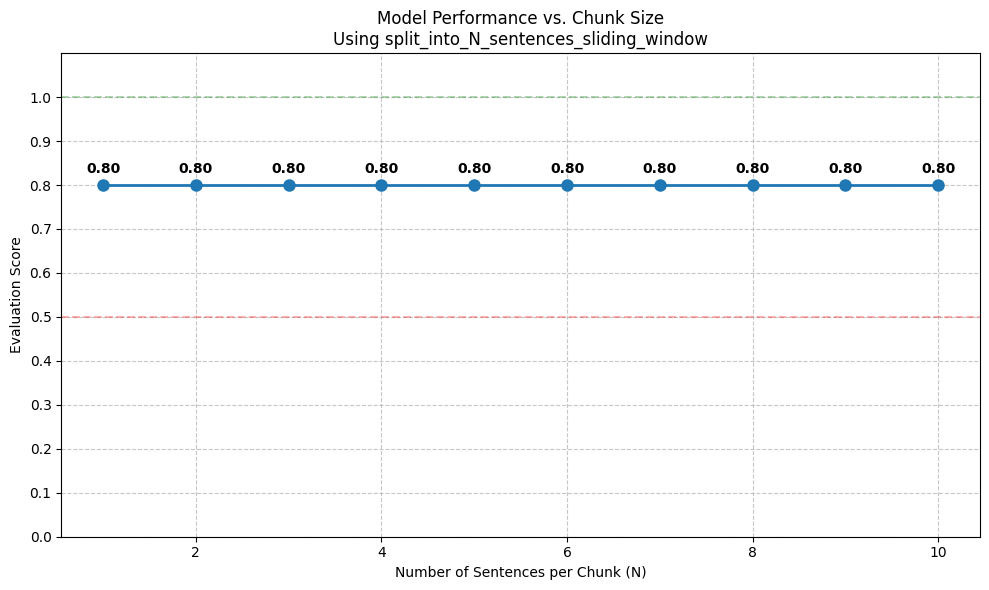


Optimal chunk size with split_into_N_sentences_sliding_window: 1 sentences per chunk (score: 0.80)

Optimal chunk size: 1 sentences per chunk (score: 0.80)


In [ ]:
# # # Example usage
# max_N = 10  # Test N from 1 to 10
# N_values, scores = evaluate_different_chunk_sizes(sentences, split_function = split_into_N_sentences_sliding_window, max_N=max_N, debug_print=False)

# # Only find optimal if we have results
# if scores:
#     optimal_N = N_values[scores.index(max(scores))]
#     print(f"\nOptimal chunk size: {optimal_N} sentences per chunk (score: {max(scores):.2f})")

Number of sentences: 257
Number of queries in data: 10
Testing with regular chunking method...
Evaluating different chunk sizes using split_into_N_sentences...
Testing with 1 sentences per chunk...
Number of semantic chunks: 257
First text chunk: Understanding Artificial Intelligence 
Chapter 1: Introduction to Artificial Intelligence 
Artificia...

Processing query 1/10: What is 'Explainable AI' and why is it considered important?
  Score: 0.8

Processing query 2/10: Can AI be used to predict earthquakes?
  Score: 1.0

Processing query 3/10: What are some of the ethical concerns related to AI-powered facial recognition?
  Score: 1.0

Processing query 4/10: How does AI contribute to personalized medicine?
  Score: 0.5

Processing query 5/10: Does the document mention any specific companies developing AI technology?
  Score: 1.0

Processing query 6/10: What is the role of AI in smart grids?
  Score: 0.5

Processing query 7/10: Can AI write a complete, original novel?
  Score: 1.0

Proce

C:\Users\Hassan\AppData\Local\Temp\ipykernel_33728\1298660570.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=N_values)


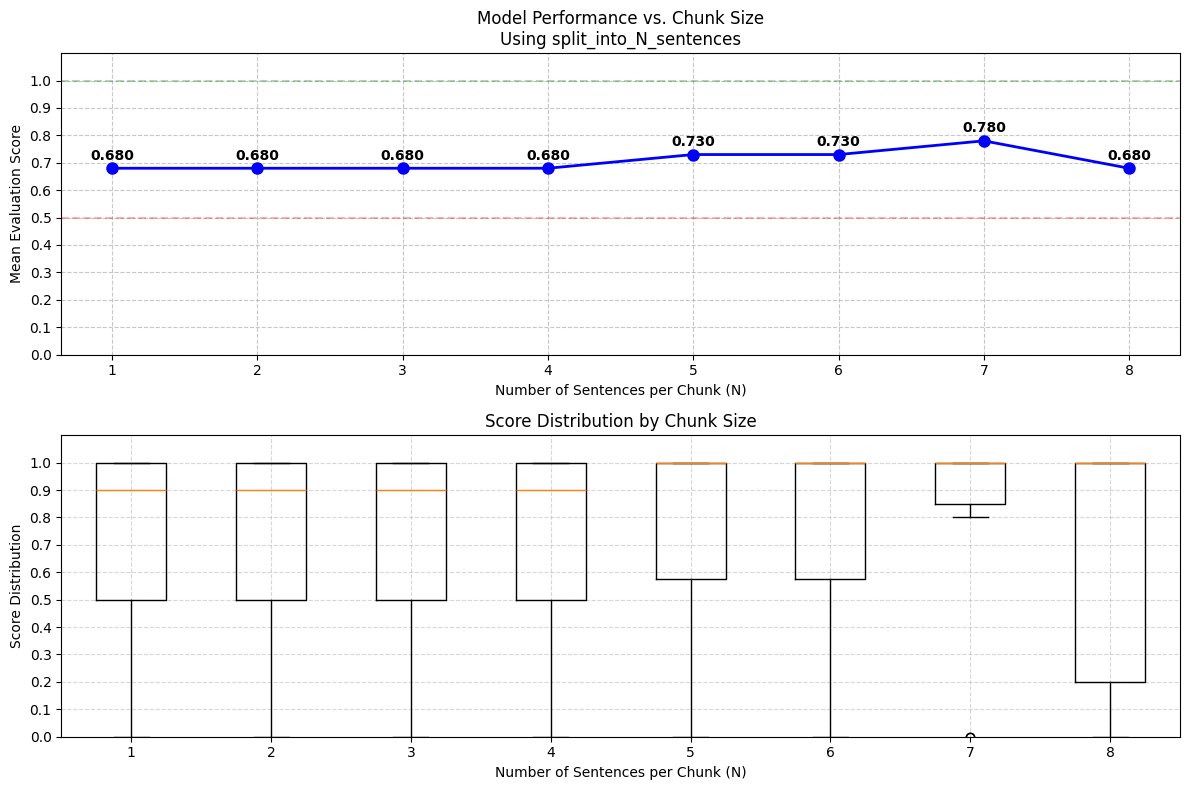


Optimal chunk size with split_into_N_sentences: 7 sentences per chunk
Mean score: 0.780
Score distribution for optimal N=7:
  Min: 0.000
  Max: 1.000
  Median: 1.000

Testing with sliding window chunking method...
Evaluating different chunk sizes using split_into_N_sentences_sliding_window...
Testing with 1 sentences per chunk...
Number of semantic chunks: 257
First text chunk: Understanding Artificial Intelligence 
Chapter 1: Introduction to Artificial Intelligence 
Artificia...

Processing query 1/10: What is 'Explainable AI' and why is it considered important?
  Score: 0.8

Processing query 2/10: Can AI be used to predict earthquakes?
  Score: 1.0

Processing query 3/10: What are some of the ethical concerns related to AI-powered facial recognition?
  Score: 1.0

Processing query 4/10: How does AI contribute to personalized medicine?
  Score: 0.5

Processing query 5/10: Does the document mention any specific companies developing AI technology?
  Score: 1.0

Processing query 6/10: W

C:\Users\Hassan\AppData\Local\Temp\ipykernel_33728\1298660570.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=N_values)


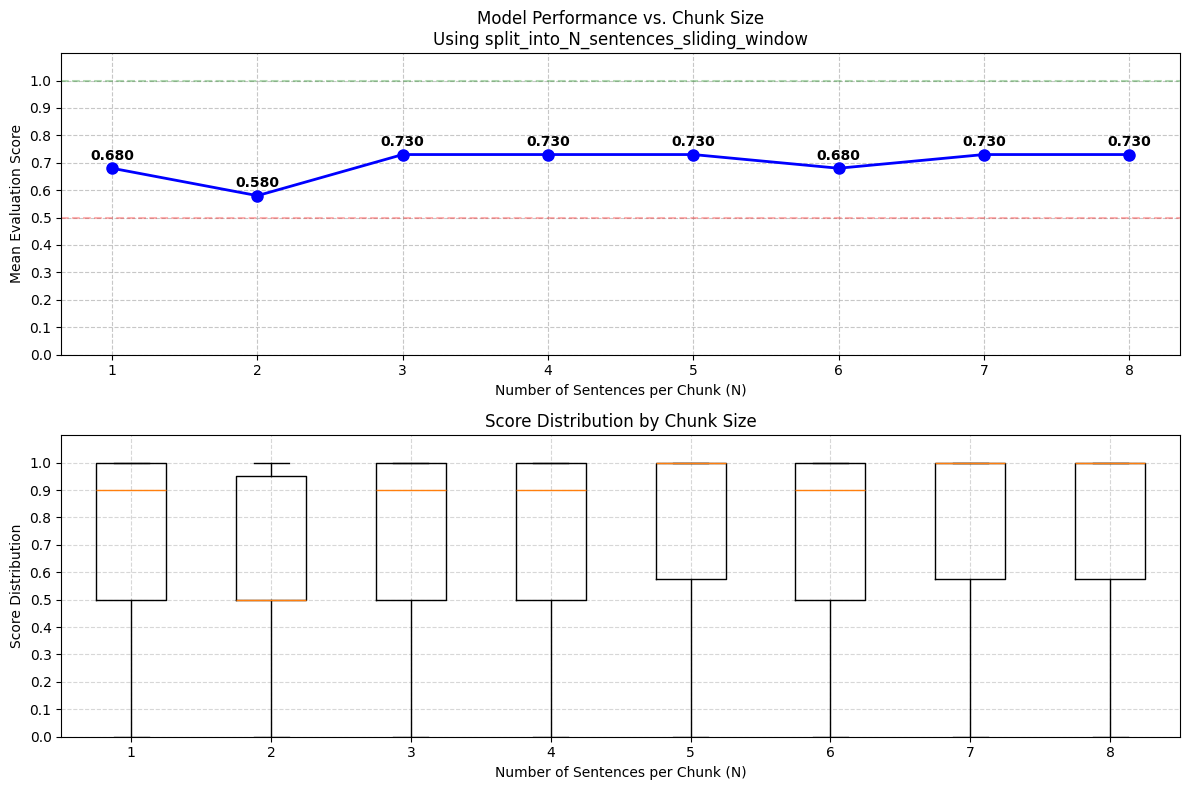


Optimal chunk size with split_into_N_sentences_sliding_window: 3 sentences per chunk
Mean score: 0.730
Score distribution for optimal N=3:
  Min: 0.000
  Max: 1.000
  Median: 0.900

Best Performance Summary:
Regular chunking: N=7, Score=0.780
Sliding window: N=3, Score=0.730

Regular chunking shows 6.85% improvement over sliding window


In [46]:
# Run evaluation for different chunk sizes using all queries
import matplotlib.pyplot as plt
import numpy as np

# Check that data and sentences are loaded
print(f"Number of sentences: {len(sentences)}")
print(f"Number of queries in data: {len(data)}")

# Set parameters
max_N = 8  # Test N from 1 to 8

# Run the evaluation with default chunking method for all queries
print("Testing with regular chunking method...")
N_values_regular, mean_scores_regular, all_scores_regular = mean_scores_for_all_chunk_sizes(
    sentences=sentences,
    split_function=split_into_N_sentences,  # Regular chunking
    max_N=max_N,
    debug_print=True,
    max_queries=None  # Process all queries
)

# Run the evaluation with sliding window chunking method for all queries
print("\nTesting with sliding window chunking method...")
N_values_sliding, mean_scores_sliding, all_scores_sliding = mean_scores_for_all_chunk_sizes(
    sentences=sentences,
    split_function=split_into_N_sentences_sliding_window,  # Sliding window chunking
    max_N=max_N,
    debug_print=True,
    max_queries=None  # Process all queries
)

# Compare the two methods
if mean_scores_regular and mean_scores_sliding:
    best_regular = max(mean_scores_regular)
    best_sliding = max(mean_scores_sliding)
    
    print("\nBest Performance Summary:")
    print(f"Regular chunking: N={N_values_regular[mean_scores_regular.index(best_regular)]}, Score={best_regular:.3f}")
    print(f"Sliding window: N={N_values_sliding[mean_scores_sliding.index(best_sliding)]}, Score={best_sliding:.3f}")
    
    if best_sliding > best_regular:
        improvement = ((best_sliding - best_regular) / best_regular) * 100
        print(f"\nSliding window shows {improvement:.2f}% improvement over regular chunking")
    elif best_regular > best_sliding:
        improvement = ((best_regular - best_sliding) / best_sliding) * 100
        print(f"\nRegular chunking shows {improvement:.2f}% improvement over sliding window")
    else:
        print("\nBoth methods perform equally well")

In [33]:
# import matplotlib.pyplot as plt
# import numpy as np

# def evaluate_different_chunk_sizes(sentences, max_N=10, json_file_path='data/val.json', debug_print=False):
#     """
#     Evaluate model performance with different chunk sizes (N sentences)
#     and plot the results.
    
#     Parameters:
#     -----------
#     sentences : list
#         List of sentences to process
#     max_N : int, optional
#         Maximum number of sentences per chunk to test (default: 10)
#     json_file_path : str, optional
#         Path to the validation data JSON file (default: 'data/val.json') 
#     debug_print : bool, optional
#         Whether to print debug information (default: False)
        
#     Returns:
#     --------
#     tuple
#         N_values and corresponding scores
#     """
#     N_values = list(range(1, max_N + 1))
#     scores = []
    
#     print("Evaluating different chunk sizes...")
    
#     # Loop through different values of N
#     for N in N_values:
#         print(f"Testing with {N} sentences per chunk...")
        
#         # Process and evaluate with current N
#         eval_response, _, _, _, _ = process_and_evaluate(
#             sentences, 
#             N=N, 
#             json_file_path=json_file_path, 
#             debug_print=debug_print
#         )
        
#         # Extract the score from the evaluation response
#         score = extract_score(eval_response.choices[0].message.content)
#         scores.append(score)
        
#         print(f"  - Score: {score}")
    
#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(N_values, scores, 'o-', linewidth=2, markersize=8)
#     plt.xlabel('Number of Sentences per Chunk (N)')
#     plt.ylabel('Evaluation Score')
#     plt.title('Model Performance vs. Chunk Size')
#     plt.grid(True, linestyle='--', alpha=0.7)
    
#     # Add value labels above each point
#     for i, score in enumerate(scores):
#         plt.text(N_values[i], score + 0.02, f'{score:.2f}', 
#                 ha='center', va='bottom', fontweight='bold')
    
#     # Format the y-axis to show scores between 0 and 1
#     plt.ylim([0, 1.1])
#     plt.yticks(np.arange(0, 1.1, 0.1))
    
#     # Add horizontal lines to make it easier to read the chart
#     plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
#     plt.axhline(y=1.0, color='g', linestyle='--', alpha=0.3)
    
#     plt.tight_layout()
#     plt.savefig('chunk_size_performance.png')
#     plt.show()
    
#     return N_values, scores

# # Example usage
# max_N = 10  # Test N from 1 to 10
# N_values, scores = evaluate_different_chunk_sizes(sentences, max_N=max_N, debug_print=False)

# # Find the optimal chunk size
# optimal_N = N_values[scores.index(max(scores))]
# print(f"\nOptimal chunk size: {optimal_N} sentences per chunk (score: {max(scores):.2f})")

Evaluating different chunk sizes...
Testing with 1 sentences per chunk...
  - Score: 0.8
Testing with 2 sentences per chunk...
  - Score: 0.8
Testing with 3 sentences per chunk...
  - Score: 0.8
Testing with 4 sentences per chunk...
  - Score: 0.8
Testing with 5 sentences per chunk...
  - Score: 0.5
Testing with 6 sentences per chunk...
  - Score: 0.8
Testing with 7 sentences per chunk...
  - Score: 0.8
Testing with 8 sentences per chunk...
  - Score: 0.8
Testing with 9 sentences per chunk...
  - Score: 0.8
Testing with 10 sentences per chunk...
  - Score: 0.8


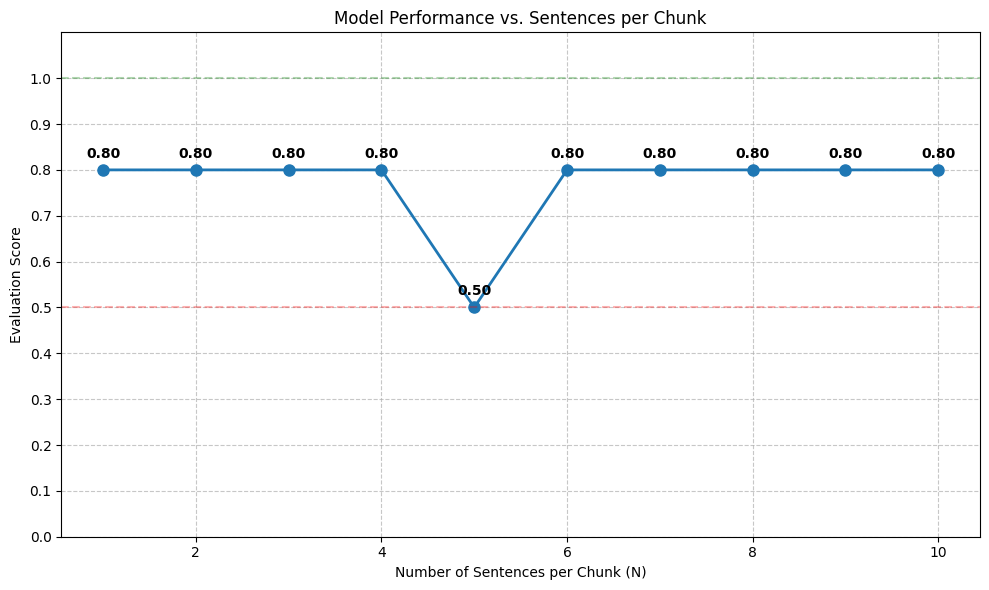


Optimal chunk size: 1 sentences per chunk (score: 0.80)

Optimal chunk size: 1 sentences per chunk (score: 0.80)


In [ ]:
# # import matplotlib.pyplot as plt
# # import numpy as np

# # def evaluate_different_chunk_sizes(sentences, max_N=10, json_file_path='data/val.json', debug_print=False):
# #     """
# #     Evaluate model performance with different chunk sizes (N sentences)
# #     and plot the results.
    
# #     Parameters:
# #     -----------
# #     sentences : list
# #         List of sentences to process
# #     max_N : int, optional
# #         Maximum number of sentences per chunk to test (default: 10)
# #     json_file_path : str, optional
# #         Path to the validation data JSON file (default: 'data/val.json') 
# #     debug_print : bool, optional
# #         Whether to print debug information (default: False)
        
# #     Returns:
# #     --------
# #     tuple
# #         N_values and corresponding scores
# #     """
# #     N_values = []
# #     scores = []
    
# #     print("Evaluating different chunk sizes...")
    
# #     # Loop through different values of N
# #     for N in range(1, max_N + 1):
# #         print(f"Testing with {N} sentences per chunk...")
        
# #         # Process and evaluate with current N
# #         eval_response, _, _, _, _ = process_and_evaluate(
# #             sentences, 
# #             N=N, 
# #             json_file_path=json_file_path, 
# #             debug_print=debug_print
# #         )
        
# #         # Extract the score from the evaluation response
# #         score = extract_score(eval_response.choices[0].message.content)
        
# #         # Only add to results if we got a valid score
# #         if score is not None:
# #             N_values.append(N)
# #             scores.append(score)
# #             print(f"  - Score: {score}")
# #         else:
# #             print(f"  - No score found in evaluation response for N={N}")
    
# #     # Only create plot if we have data
# #     if len(scores) > 0:
# #         plt.figure(figsize=(10, 6))
# #         plt.plot(N_values, scores, 'o-', linewidth=2, markersize=8)
# #         plt.xlabel('Number of Sentences per Chunk (N)')
# #         plt.ylabel('Evaluation Score')
# #         plt.title('Model Performance vs. Sentences per Chunk')
# #         plt.grid(True, linestyle='--', alpha=0.7)
        
# #         # Add value labels above each point
# #         for i, score in enumerate(scores):
# #             plt.text(N_values[i], score + 0.02, f'{score:.2f}', 
# #                     ha='center', va='bottom', fontweight='bold')
        
# #         # Format the y-axis to show scores between 0 and 1
# #         plt.ylim([0, 1.1])
# #         plt.yticks(np.arange(0, 1.1, 0.1))
        
# #         # Add horizontal lines to make it easier to read the chart
# #         plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
# #         plt.axhline(y=1.0, color='g', linestyle='--', alpha=0.3)
        
# #         plt.tight_layout()
# #         plt.savefig('chunk_size_performance.png')
# #         plt.show()
        
# #         # Find the optimal chunk size
# #         optimal_N = N_values[scores.index(max(scores))]
# #         print(f"\nOptimal chunk size: {optimal_N} sentences per chunk (score: {max(scores):.2f})")
# #     else:
# #         print("No valid scores found for any chunk size. Check the evaluation responses.")
    
# #     return N_values, scores

# # Improved score extraction function with more patterns
# def extract_score(evaluation_text):
#     """
#     Extract the numerical score from an evaluation text with improved pattern matching.
    
#     Parameters:
#     -----------
#     evaluation_text : str
#         The evaluation text containing a score
        
#     Returns:
#     --------
#     float
#         The extracted score, or None if no score is found
#     """
#     import re
    
#     # Try multiple patterns to find the score
#     patterns = [
#         r"score of (\d+\.?\d*)",  # "score of 0.8"
#         r"assign a score of (\d+\.?\d*)",  # "assign a score of 0.8"
#         r"score: (\d+\.?\d*)",  # "score: 0.8"
#         r"score is (\d+\.?\d*)",  # "score is 0.8"
#         r"score would be (\d+\.?\d*)",  # "score would be 0.8"
#         r"score: (\d+\.?\d*)/1\.0",  # "score: 0.8/1.0"
#         r"rating of (\d+\.?\d*)"  # "rating of 0.8"
#     ]
    
#     for pattern in patterns:
#         match = re.search(pattern, evaluation_text.lower())
#         if match:
#             try:
#                 # Extract the score and convert it to float
#                 score = float(match.group(1))
#                 return score
#             except ValueError:
#                 # If conversion fails, try the next pattern
#                 continue
    
#     # If no pattern matches or all conversions fail, return None
#     return None

# # Example usage
# max_N = 10  # Test N from 1 to 10
# N_values, scores = evaluate_different_chunk_sizes(sentences, max_N=max_N, debug_print=False)

# # Only find optimal if we have results
# if scores:
#     optimal_N = N_values[scores.index(max(scores))]
#     print(f"\nOptimal chunk size: {optimal_N} sentences per chunk (score: {max(scores):.2f})")

In [ ]:
# # test code for process and evaluate
# Num_of_Sentences = 5
# evalu_response, _, _, _, _ = process_and_evaluate(sentences, N = Num_of_Sentences)
# score = extract_score(evalu_response.choices[0].message.content)
# # evalu_response.choices[0].message.content


'Based on the evaluation criteria, I would assign a score of 0.8 to the AI assistant\'s response.\n\nThe response is very close to the true response, covering the essential points of Explainable AI (XAI) and its importance. The AI assistant correctly mentions the key reasons why XAI is considered important, including enhancing trust, improving accountability, addressing potential harms, and ensuring ethical behavior.\n\nHowever, the response could be improved by providing more specific and detailed explanations of each point. The true response mentions "fairness" as a key aspect of XAI, which is not explicitly mentioned in the AI assistant\'s response. Nevertheless, the overall content and structure of the response are accurate and align well with the true response.'

In [26]:
# resutls
extract_score(evalu_response.choices[0].message.content)

0.8

In [ ]:
# # Create chunks using the split_into_chunks function
# N = 3
# text_chunks = split_into_N_sentences(sentences, N)

# # Print the number of chunks created
# print(f"Number of semantic chunks: {len(text_chunks)}")

# # Print the first chunk to verify the result
# print("\nFirst text chunk:")
# print(text_chunks[0])


# # Create chunk embeddings using the create_embeddings function
# chunk_embeddings = create_embeddings(text_chunks)


# # Load the validation data from a JSON file
# with open('data/val.json') as f:
#     data = json.load(f)

# # Extract the first query from the validation data
# query = data[0]['question']
# # query = "How does AI's reliance on massive data sets act as a double-edged sword?"

# # Get top 2 relevant chunks
# top_chunks = semantic_search(query, text_chunks, chunk_embeddings, k=2)

# # Print the query
# print(f"Query: {query}")

# # Print the top 2 most relevant text chunks
# for i, chunk in enumerate(top_chunks):
#     print(f"Context {i+1}:\n{chunk}\n{'='*40}")



# # Define the system prompt for the AI assistant
# system_prompt = "You are an AI assistant that strictly answers based on the given context. If the answer cannot be derived directly from the provided context, respond with: 'I do not have enough information to answer that.'"

# # Create the user prompt based on the top chunks
# user_prompt = "\n".join([f"Context {i + 1}:\n{chunk}\n=====================================\n" for i, chunk in enumerate(top_chunks)])
# user_prompt = f"{user_prompt}\nQuestion: {query}"

# # Generate AI response
# ai_response = generate_response(system_prompt, user_prompt)




# # Define the system prompt for the evaluation system
# evaluate_system_prompt = "You are an intelligent evaluation system tasked with assessing the AI assistant's responses. If the AI assistant's response is very close to the true response, assign a score of 1. If the response is incorrect or unsatisfactory in relation to the true response, assign a score of 0. If the response is partially aligned with the true response, assign a score of 0.5."

# # Create the evaluation prompt by combining the user query, AI response, true response, and evaluation system prompt
# evaluation_prompt = f"User Query: {query}\nAI Response:\n{ai_response.choices[0].message.content}\nTrue Response: {data[0]['ideal_answer']}\n{evaluate_system_prompt}"

# # Generate the evaluation response using the evaluation system prompt and evaluation prompt
# evaluation_response = generate_response(evaluate_system_prompt, evaluation_prompt)

# # Print the evaluation response
# print(evaluation_response.choices[0].message.content)

In [ ]:
# base case
# # Define the system prompt for the evaluation system
# evaluate_system_prompt = "You are an intelligent evaluation system tasked with assessing the AI assistant's responses. If the AI assistant's response is very close to the true response, assign a score of 1. If the response is incorrect or unsatisfactory in relation to the true response, assign a score of 0. If the response is partially aligned with the true response, assign a score of 0.5."

# # Create the evaluation prompt by combining the user query, AI response, true response, and evaluation system prompt
# evaluation_prompt = f"User Query: {query}\nAI Response:\n{ai_response.choices[0].message.content}\nTrue Response: {data[0]['ideal_answer']}\n{evaluate_system_prompt}"

# # Generate the evaluation response using the evaluation system prompt and evaluation prompt
# evaluation_response = generate_response(evaluate_system_prompt, evaluation_prompt)

# # Print the evaluation response
# print(evaluation_response.choices[0].message.content)

Score: 0.8

The AI assistant's response is mostly aligned with the true response, but there are some minor differences. The true response mentions that Explainable AI (XAI) provides insights into how AI systems make decisions, which is not explicitly mentioned in the AI assistant's response. However, the overall meaning and importance of XAI are correctly conveyed.


### examine Data

### 